In [1]:
%%sh
pip install openpyxl --quiet 
pip install lifelines --quiet
pip install scikit-learn --quiet
pip install seaborn --quiet


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# weird bug in XLSX loading creates annoying warnings, let's turn those off here
import warnings
warnings.simplefilter("ignore")



In [3]:
# patient survival and neoantigen prediction: 
#     A neoantigen fitness model predicts tumour response to checkpoint blockade immunotherapy 
#     https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6137806/
!ls ../data/nature*.xlsx

../data/nature24473_MOESM4_neoantigens.xlsx
../data/nature24473_MOESM5_survival.xlsx


In [4]:
# Luksza 2017 uses three cohorts of checkpoint trial data:
# - Snyder 2014
# - Van Allen 2015
# - Rizvi 2015
cohort_names = [
    "VanAllen",
    "Snyder",
    "Rizvi",
]

In [5]:
# load Luksza 2017 survival data
survival_dataframes = []
for s in cohort_names:
    print("Loading survival data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM5_survival.xlsx", sheet_name="Survival %s et al." % s)
    # convert 0/1 to False/True
    df["Status"] = df["Status"].astype(bool)
    df["Cohort"] = s
    survival_dataframes.append(df)
    
df_survival = pd.concat(survival_dataframes)

# let's create some binary targets by thresholding survival times

df_survival["survived_1yr"] = df_survival.Months >= 12
df_survival["survived_2yr"] = df_survival.Months >= 24
df_survival["survived_3yr"] = df_survival.Months >= 36

# also, let's note when we know if a patient got to the thresholded time 
# by either surviving that long or dying previously
df_survival["known_at_1yr"] = df_survival.survived_1yr | df_survival.Status
df_survival["known_at_2yr"] = df_survival.survived_2yr | df_survival.Status
df_survival["known_at_3yr"] = df_survival.survived_3yr | df_survival.Status

df_survival


Loading survival data for VanAllen...
Loading survival data for Snyder...
Loading survival data for Rizvi...


,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...
29,GR0134,21.900000,False,Rizvi,True,False,False,True,False,False
30,VA1330,23.400000,True,Rizvi,True,False,False,True,True,True
31,NI9507,27.900000,False,Rizvi,True,True,False,True,True,False
32,AU5884,2.400000,True,Rizvi,False,False,False,True,True,True


In [6]:
# load Luksza 2017 neoantigen data

neoag_dataframes = []
for s in cohort_names:
    print("Loading neoantigens data for %s..." % (s,))
    df = pd.read_excel("../data/nature24473_MOESM4_neoantigens.xlsx", sheet_name=s + " et al.")
    df["Cohort"] = s
    neoag_dataframes.append(df)
    
df_neoag = pd.concat(neoag_dataframes);
df_neoag


Loading neoantigens data for VanAllen...
Loading neoantigens data for Snyder...
Loading neoantigens data for Rizvi...


,ID,MUTATION_ID,Sample,WT.Peptide,MT.Peptide,MT.Allele,WT.Score,MT.Score,HLA,Cohort
0,1,1_1563747_C_T_Pat02,Pat02,NHREVAQIL,NYREVAQIL,C0702,701,70,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
1,2,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0801,739,202,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
2,3,1_17087582_G_A_Pat02,Pat02,SPSNDFQVL,SPLNDFQVL,B0702,32,37,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
3,4,1_21806573_A_G_Pat02,Pat02,LLDEKEPEV,LLDEKGPEV,A0201,8,9,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
4,5,1_46073697_C_T_Pat02,Pat02,KPGQEAPVL,KPGQEASVL,B0702,90,31,"A0201,A2601,B0801,B0702,C0702,C0702",VanAllen
...,...,...,...,...,...,...,...,...,...,...
4943,4944,8_113697930_C_A_ZA6965,ZA6965,CLSNFTAPM,CLSNFTAPI,A3201,1850,71,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4944,4945,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A0201,419,172,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4945,4946,X_68749680_T_A_ZA6965,ZA6965,RLCVLVLML,RLSVLVLML,A3201,516,314,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi
4946,4947,X_68749680_T_A_ZA6965,ZA6965,SRIRLCVLV,SRIRLSVLV,C0602,751,146,"A0201,A3201,A0289,B400102,B450101,C0602,C0304",Rizvi


In [7]:
# to create a source of random sequence data for each patient to use a source for featurization
# let's take the top-3 neoantigens ranked by MHC binding affinity

top_3_neoags_per_sample = df_neoag.sort_values("MT.Score").groupby("Sample").head(3).groupby("Sample")["MT.Peptide"].apply("|".join);
top_3_neoags_per_sample.name = "Top_3_Neoantigen_Sequences"
top_3_neoags_per_sample

Sample
AL4602    KMFLAVLSF|KILQLTLNF|KVVYFMATF
AU5884    RYVAIYNPI|LLLEKVEFL|NYIFRLFQF
BL3403    ITDFGHSEI|ILDECQNLM|MPTMASVKL
CA9903    ILYGYWWPL|YLNELVVFV|FLHEIFHQV
CR0095    YLMDWMKEM|FIFGDTILV|FMIGSMELI
                      ...              
TU0428    IPFAVILPF|YPFLGAVCF|MAVCHPLQY
WA7899    KFMAVFYTI|QAEYATIVF|TPTDNANSF
Y2087     KQYQKEAYR|CPLLNITAM|KMGKCCHHR
ZA6505    NEYDLWTAY|FAFLLVSYV|MAYDRYVAI
ZA6965    FLNFLILVV|STSQGTFTF|ALPPCLIPL
Name: Top_3_Neoantigen_Sequences, Length: 205, dtype: object

In [8]:
# let's sanity check the sequences for the first sample AL4602

AL4602_neoags = df_neoag[df_neoag.Sample == "AL4602"].sort_values("MT.Score");
AL4602_neoags


,ID,MUTATION_ID,Sample,WT.Peptide,MT.Peptide,MT.Allele,WT.Score,MT.Score,HLA,Cohort
25,26,12_21007975_C_T_AL4602,AL4602,KMFLAALSF,KMFLAVLSF,A3201,4,3,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
57,58,2_163361083_G_A_AL4602,AL4602,KIPQLTLNF,KILQLTLNF,A3201,17,6,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
10,11,11_20648267_C_T_AL4602,AL4602,KVVYFTATF,KVVYFMATF,A3201,5,11,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
15,16,11_56114447_A_T_AL4602,AL4602,RTLTNRFKI,RTFTNRFKI,A3201,36,14,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
45,46,16_57188221_G_C_AL4602,AL4602,SSIFRTNTF,SSIFRTNSF,A3201,13,17,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
...,...,...,...,...,...,...,...,...,...,...
19,20,11_63137761_C_A_AL4602,AL4602,ISIPLDSNM,ISIQLDSNM,C1502,310,452,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
9,10,10_73579374_C_T_AL4602,AL4602,LTVHVTQPK,LTVHMTQPK,A0301,442,460,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
74,75,5_170239030_G_A_AL4602,AL4602,SFKRKISFA,SFKQKISFA,B0801,212,470,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi
76,77,6_32714125_A_G_AL4602,AL4602,TVFIIQGLR,TVFIIRGLR,A0301,471,494,"A0301,A3201,B0801,B5101,C0702,C1502",Rizvi


In [9]:
print(top_3_neoags_per_sample["AL4602"])
print("|".join(AL4602_neoags["MT.Peptide"][:3]))
top_3_neoags_per_sample["AL4602"] == "|".join(AL4602_neoags["MT.Peptide"][:3])

KMFLAVLSF|KILQLTLNF|KVVYFMATF
KMFLAVLSF|KILQLTLNF|KVVYFMATF


True

In [10]:
# now let's join the neoag and survival tables 
# (dropping some patients since the samples in these tables don't perfectly match)

df_join = df_survival.join(top_3_neoags_per_sample, on="Sample", how="inner");
df_join_left = df_survival.join(top_3_neoags_per_sample, on="Sample", how="left");
print(len(df_join_left), "vs.", len(df_join))
df_join

201 vs. 198


,Sample,Months,Status,Cohort,survived_1yr,survived_2yr,survived_3yr,known_at_1yr,known_at_2yr,known_at_3yr,Top_3_Neoantigen_Sequences
0,Pat02,53.654736,False,VanAllen,True,True,True,True,True,True,WMLRKHHSF|MAWGSLFHV|MLRKHHSFA
1,Pat03,3.287668,True,VanAllen,False,False,False,True,True,True,WPADAPFWM|HPRAVSISF|IAFSYWSVY
2,Pat04,32.449280,False,VanAllen,True,True,False,True,True,False,YAYIIKTIL|LAAPMSRSL|TLFPFLFVV
3,Pat06,5.293145,True,VanAllen,False,False,False,True,True,True,AAIPPPPPL|FAASQKEEL|YSSDSSVTL
4,Pat08,4.602735,True,VanAllen,False,False,False,True,True,True,LAVMAYDCY|MVHNLVPPY|FPHIFGFTL
...,...,...,...,...,...,...,...,...,...,...,...
27,LO3793,6.800000,False,Rizvi,False,False,False,False,False,False,WLLALSPNL|GLLAGTLAV|MLSELSIII
28,LO5004,22.700000,True,Rizvi,True,False,False,True,True,True,FAFLSVEDL|FALLSNTGF|FVFLAALFL
29,GR0134,21.900000,False,Rizvi,True,False,False,True,False,False,TRSTHNLKV|QHHHHHHHL|RLIYAVHLA
31,NI9507,27.900000,False,Rizvi,True,True,False,True,True,False,GLLEALLPV|YMLTLHTKL|LMIRWLRGV


p-value = 7.3310511199250725e-59


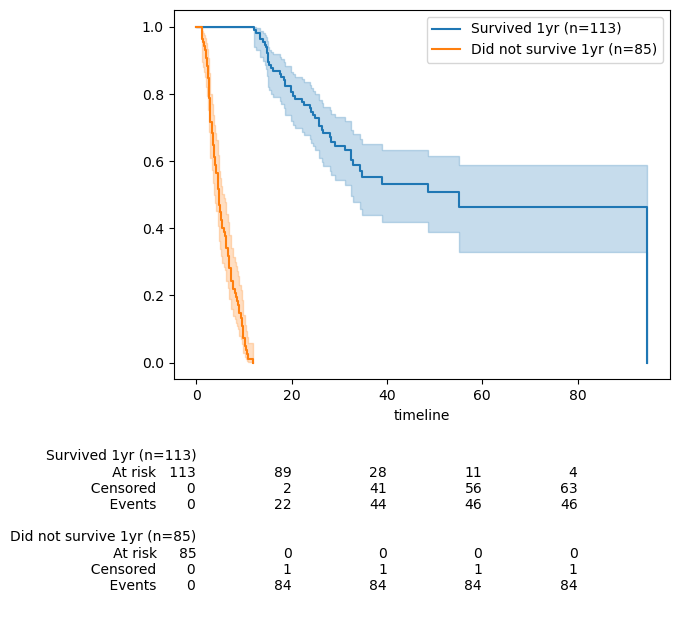

In [11]:
# sanity check that 1yr binary survival threshold is still a good basis for splitting the survival curves
# on our 198 patient subset

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts


ax = plt.subplot(111)

# plot the 1yr survivors
df_yes = df_join[df_join.survived_1yr]
kmf_yes = KaplanMeierFitter()
kmf_yes.fit(df_yes.Months, 
        event_observed=df_yes.Status, 
        label="Survived 1yr (n=%d)" % len(df_yes))  
kmf_yes.plot_survival_function(ax=ax)

# plot the 1yr non-survivors
df_no = df_join[~df_join.survived_1yr]
kmf_no = KaplanMeierFitter()
kmf_no.fit(df_no.Months, 
        event_observed=df_no.Status, 
        label="Did not survive 1yr (n=%d)" % len(df_no))
kmf_no.plot_survival_function(ax=ax)
add_at_risk_counts(kmf_yes, kmf_no)


from lifelines.statistics import logrank_test
hypothesis_test_result = logrank_test(df_yes.Months, df_no.Months, event_observed_A=df_yes.Status, event_observed_B=df_no.Status)
print("p-value = %s" % (hypothesis_test_result.p_value,))

In [12]:
# LET'S GENERATE SOME FEATURES!

# given a column of a dataframe, generate all counts of combinations up to length k

from tqdm import tqdm

def remove_duplicate_features(counts):
    dedup = {}
    print("Looking for duplicate columns")
    sums = {name: values.sum() for (name, values) in counts.items()}
    unique_values = {name: set(values) for (name, values) in counts.items()}
    for name, values in tqdm(counts.items()):
        found_duplicate = False
        for other_name, other_values in dedup.items():
            if (sums[name] == sums[other_name] and
                    (unique_values[name] == unique_values[other_name]) and 
                    (values == other_values).all()):
                found_duplicate = True
                break
        if not found_duplicate:
            dedup[name] = values
    print("Removed %d duplicate features" % (len(counts) - len(dedup)))
    return dedup

def generate_kmer_features(column, k=1, ignore=set(), include_lower_order=True, remove_duplicates=True):
    assert k >= 1
    unique_values = sorted(set("".join(column)).difference(ignore))
    print("Unique tokens in %s: %s" % (column.name, unique_values))
    counts = {}

    print("Generating singleton count features...")
    for c in tqdm(unique_values):
        counts[c] = np.array([p.count(c) for p in column])
    
    for i in range(2, k + 1):
        higher_order_counts = {}
        print("Generating counts of %d characters" % (i,))
   
        for old_name, old_feature_values in tqdm(list(counts.items())):
            for c in unique_values:
                combo = old_name + c
                vec = np.array([p.count(combo) for p in column])
                if vec.sum() == 0:
                    # skip vectors of all 0s
                    continue
                higher_order_counts[combo] = vec
        
        counts.update(higher_order_counts)
    if not include_lower_order:
        counts = {name: values for (name, values) in counts if len(name) == k}
    if remove_duplicates:
        counts = remove_duplicate_features(counts)
    print("Total number of generated features = %d" % (len(counts),))
    return pd.DataFrame(counts, index=column.index);

In [13]:
# generate raw features to use in a classifier from amino acid content of the top 3 neoantigens
df_new_features_1 = generate_kmer_features(df_join.Top_3_Neoantigen_Sequences, k=1, ignore="|")
df_new_features_1

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 13567.21it/s]


Looking for duplicate columns


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 352462.52it/s]

Removed 0 duplicate features
Total number of generated features = 20


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,2,0,0,0,3,1,5,0,2,3,3,0,0,0,2,3,0,1,2,0
1,4,0,1,0,3,0,1,2,0,0,1,0,3,0,1,4,0,2,3,2
2,3,0,0,0,3,0,0,3,1,5,1,0,2,0,1,2,2,2,0,2
3,4,0,1,2,1,0,0,1,1,3,0,0,5,1,0,5,1,1,0,1
4,2,1,1,0,3,1,2,1,0,3,2,1,3,0,0,0,1,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,1,1,1,0,0,3,1,1,1,0
28,4,0,1,1,7,1,0,0,0,7,0,1,0,0,0,2,1,2,0,0
29,2,0,0,0,0,0,9,1,1,4,0,1,0,1,2,1,2,2,0,1
31,1,0,0,1,0,2,1,1,1,9,2,0,1,0,2,0,2,2,1,1


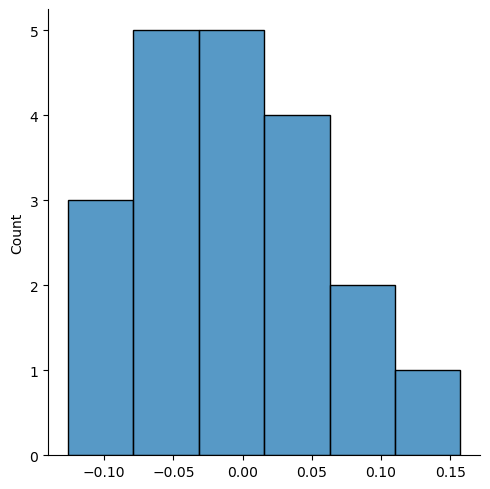

In [14]:
# get the correlation of every feature with the target label
correlations_1 = df_new_features_1.corrwith(df_join.survived_1yr);
# plot the distribution of random correlations
g = sns.displot(correlations_1)
g.savefig("label-correlation-with-k1-aa-counts-histogram.png")

In [15]:
# generate raw features to use in a classifier from the PATIENT/SAMPLE IDs (!!)
df_new_features_2 = generate_kmer_features(df_join.Top_3_Neoantigen_Sequences, k=2, ignore="|")
df_new_features_2

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 7293.81it/s]


Generating counts of 2 characters


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 956.21it/s]


Looking for duplicate columns


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 41637.56it/s]

Removed 1 duplicate features
Total number of generated features = 412


,A,C,D,E,F,G,H,I,K,L,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
0,2,0,0,0,3,1,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,1,0,3,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,3,0,0,3,1,5,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,2,1,0,0,1,1,3,...,0,0,0,0,0,1,0,0,0,0
4,2,1,1,0,3,1,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,...,0,0,0,0,0,0,0,0,0,0
28,4,0,1,1,7,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
29,2,0,0,0,0,0,9,1,1,4,...,0,0,0,0,0,0,0,0,0,0
31,1,0,0,1,0,2,1,1,1,9,...,1,0,0,0,0,0,0,0,0,0


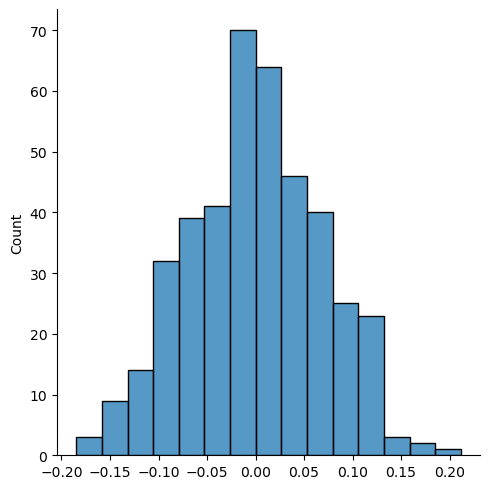

In [16]:
# get the correlation of every feature with the target label
correlations_2 = df_new_features_2.corrwith(df_join.survived_1yr);
# plot the distribution of random correlations
g = sns.displot(correlations_2)
g.savefig("label-correlation-with-k1-aa-counts-histogram.png")

In [17]:
# to look at the impact of generating more features, let's try every order of counts from 1 to 10
order_to_count_features = {}

ks = np.array([1, 2, 3, 4, 5, 6])

max_k = ks.max()
df_features_max_k = generate_kmer_features(
    df_join.Top_3_Neoantigen_Sequences, k=max_k, ignore="|", include_lower_order=True, remove_duplicates=True)
columns = df_features_max_k.columns
for k in ks:
    subset = [c for c in columns if len(c) <= k]
    order_to_count_features[k] = df_features_max_k[subset]

Unique tokens in Top_3_Neoantigen_Sequences: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Generating singleton count features...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 5632.58it/s]


Generating counts of 2 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1069.23it/s]


Generating counts of 3 characters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 413/413 [00:00<00:00, 1671.95it/s]


Generating counts of 4 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3031/3031 [00:01<00:00, 1910.82it/s]


Generating counts of 5 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6372/6372 [00:03<00:00, 1911.77it/s]


Generating counts of 6 characters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9266/9266 [00:04<00:00, 1901.38it/s]


Looking for duplicate columns


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11592/11592 [00:01<00:00, 8135.70it/s]

Removed 10076 duplicate features
Total number of generated features = 1516


In [20]:
 order_to_count_features[5]

,A,C,D,E,F,G,H,I,K,L,...,SMAL,SPSL,SSSF,SSTI,TFFI,TFSF,TLSA,TPMY,TSAA,VLLF
0,2,0,0,0,3,1,5,0,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,1,0,3,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,3,0,0,3,1,5,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,2,1,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0
4,2,1,1,0,3,1,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3,0,0,1,0,2,0,3,0,9,...,0,0,0,0,0,0,0,0,0,0
28,4,0,1,1,7,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
29,2,0,0,0,0,0,9,1,1,4,...,0,0,0,0,0,0,0,0,0,0
31,1,0,0,1,0,2,1,1,1,9,...,0,0,0,0,0,0,0,0,0,0


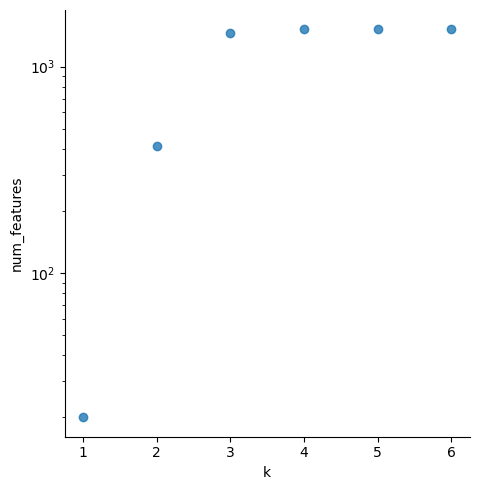

In [21]:
num_features_per_k = [
    len(order_to_count_features[k].columns) for k in ks
]
g = sns.lmplot(data=pd.DataFrame({"k": ks, "num_features": num_features_per_k}), x="k", y="num_features", fit_reg=False)
plt.yscale('log')
g.savefig("num-features-vs-k.png")

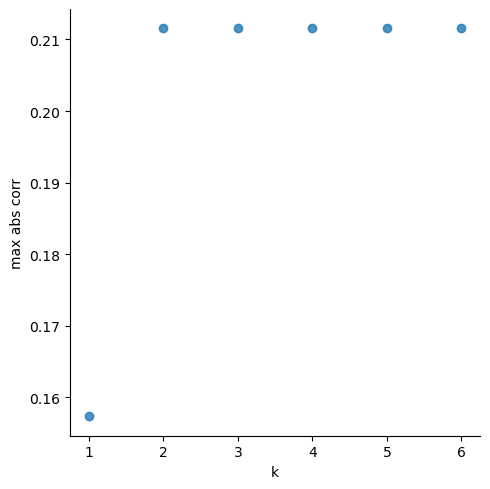

In [22]:
# as we add features, how much more chance label correlation do we get?
correlations_per_k = {}
for k in ks:
    correlations_per_k[k] = order_to_count_features[k].corrwith(df_join.survived_1yr)

top_corr_per_k = [
    correlations_per_k[k].abs().max()
    for k in ks
]
g = sns.lmplot(
    data=pd.DataFrame({"k": ks, "max abs corr": top_corr_per_k}), x="k", y="max abs corr", fit_reg=False)
g.savefig("1yr-survival-correlation-vs-k.png")


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from collections import defaultdict

# use this helper to shuffle and randomly split all the data
def generate_random_split(n, shuffle=True):
    all_indices = np.arange(n)
    if shuffle:
        np.random.shuffle(all_indices)
    train_indices = all_indices[:n//2]
    test_indices = all_indices[n//2:]
    return (train_indices, test_indices)

def select_features(feature_importance_model, X, y, max_features_to_select):
    # train a predictor on a X->y mapping and use its 
    # feature importances to select the best features
    feature_importance_model.fit(X, y)    
    # pick the top features
    feature_importances = (
        feature_importance_model.feature_importances_ 
        if hasattr(feature_importance_model, 'feature_importances_')
        else np.abs(feature_importance_model.coef_))
    return np.argsort(feature_importances)[::-1][:max_features_to_select]

def evaluate_model(
        df_survival,
        features,
        target_name="survived_1yr", 
        predictor=LogisticRegression(),
        feature_importance_model=ExtraTreesClassifier(20),
        min_features_to_select=1,
        max_features_to_select=200,
        seed=42,
        n_repeats=1,
        cheat_on_feature_selection=True,
        cheat_on_predictor_fit=False,
        randomly_permute_labels=False,
        verbose_level=1):
    
    # try to make the results repeatable by setting the same random seed
    np.random.seed(seed)
    
    # keep track of performance for every number of features evaluated
    metrics = defaultdict(list)

    best_df_yes = None
    best_df_no = None
    best_p_value = 1.0

    assert len(features) == len(df_survival)
    # lets us pass either array or DataFrame as the features
    X = features if type(features) is np.ndarray else features.values
    
    # loop over increasing numbers of features selected in the order
    # of their scores by the feature importance 
    for repeat_idx in range(n_repeats):
        if randomly_permute_labels:
            # scramble the survival DataFrame to make the ground truth labels
            # and feature values unlinked
            random_indices = np.arange(len(df_survival))
            df_survival = df_survival.iloc[random_indices]
        
        y = df_survival[target_name].values
    
        # now create distinct train and test subsets
        train_indices, test_indices = generate_random_split(len(X))

        # extract these to use for KM survival curve fitting & log-rank p-values
        df_survival_train, df_survival_test = df_survival.iloc[train_indices], df_survival.iloc[test_indices]
        X_train, X_test = X[train_indices, :], X[test_indices, :]
        y_train, y_test = y[train_indices], y[test_indices]
        if verbose_level >= 1:
            print("Repeat #%d: %dx%d training samples (%0.1f%% survival), %dx%d test samples (%0.1f%% survival), n_features %d:%d" % (
                repeat_idx + 1,
                X_train.shape[0],
                X_train.shape[1],
                y_train.mean() * 100,
                X_test.shape[0],
                X_test.shape[1],
                y_test.mean() * 100,
                min_features_to_select,
                max_features_to_select,
            ))

        # sanity check
        assert (df_survival_train[target_name] == y_train).all()
        assert (df_survival_test[target_name] == y_test).all()

        if cheat_on_feature_selection:
            feature_indices = select_features(
                feature_importance_model,
                ###
                # THIS IS THE UNKOSHER PART
                ###
                X,
                y,
                max_features_to_select=max_features_to_select)
        else:
            feature_indices = select_features(
                feature_importance_model,
                ###
                # If you choose features using just your training set then you 
                # won't get published in NEJM
                ###
                X_train,
                y_train,
                max_features_to_select=max_features_to_select)


        for n_features in range(min_features_to_select, max_features_to_select + 1):
            curr_feature_indices = feature_indices[:n_features]
            X_train_selected = X_train[:, curr_feature_indices]
            X_test_selected = X_test[:, curr_feature_indices]

            if cheat_on_predictor_fit:
                ###
                # this is beginner overfitting
                # really, much too obvious. 
                # turn this one off and look at cheat_on_feature_selection
                ###
                predictor.fit(X[:, curr_feature_indices], y)
            else:
                # this is what you're supposed to do
                predictor.fit(X_train_selected, y_train)
                
                
            y_test_scores = (
                predictor.predict_proba(X_test_selected)[:, -1]
                if hasattr(predictor, 'predict_proba')
                else predictor.predict(X_test_selected)
            )
            y_test_pred = y_test_scores > 0.5
            # skip any iterations where all test samples are labeled the same thing

            n_pred_true = y_test_pred.sum()
            if n_pred_true == 0 or n_pred_true == len(y_test):
                continue

            #
            # compute AUC, accuracy, log-rank p-value
            #
            df_yes = df_survival_test[y_test_pred]
            df_no = df_survival_test[~y_test_pred]
            metrics["repeat"].append(repeat_idx + 1)
            metrics["num_features"].append(n_features)
            # are these predictions any good?
            acc = np.mean(y_test_pred == y_test)
            metrics["accuracy"].append(acc)

            auc = roc_auc_score(y_test, y_test_scores)
            metrics["AUC"].append(auc)

            # now let's apply this predictor to split survival curves
            from lifelines.statistics import logrank_test
            hypothesis_test_result = logrank_test(
                df_yes.Months,
                df_no.Months,
                event_observed_A=df_yes.Status,
                event_observed_B=df_no.Status)
            p = hypothesis_test_result.p_value
            metrics["p"].append(p)

            if p < best_p_value:
                best_p_value = p
                best_df_yes = df_yes
                best_df_no = df_no
    metrics_df = pd.DataFrame(metrics)
    return (metrics_df, best_df_yes, best_df_no)
        



In [24]:
def plot_km(df_yes, df_no, label_yes="Yes", label_no="No", title=None, filename=None):
    """
    Plot KM curves for split survival dataframes
    """
    ax = plt.subplot(111)

    # plot the 1yr survivors
    kmf_yes = KaplanMeierFitter()
    kmf_yes.fit(df_yes.Months, 
            event_observed=df_yes.Status, 
            label=label_yes)
    kmf_yes.plot_survival_function(ax=ax)

    # plot the 1yr non-survivors
    kmf_no = KaplanMeierFitter()
    
    kmf_no.fit(df_no.Months, 
            event_observed=df_no.Status, 
            label=label_no)
    kmf_no.plot_survival_function(ax=ax)
    if title:
        plt.title(title)
    if filename:
        ax.figure.savefig(filename)
    return ax


In [26]:
# NO CHEATING (for real)
# to get started, what happens if we pick 10 features 
# and don't cheat at any stage of model construction?

metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=False,
    cheat_on_predictor_fit=False,
    min_features_to_select=10,
    max_features_to_select=10,
    n_repeats=1,
    verbose_level=0)
metrics["p"]

0    0.258721
Name: p, dtype: float64

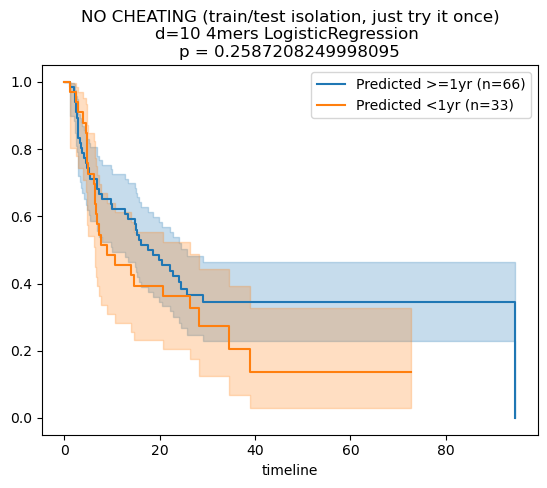

In [27]:
ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr (n=%d)" % (len(df_no),),
    title="NO CHEATING (train/test isolation, just try it once)\nd=10 4mers LogisticRegression \np = %s" % metrics["p"].min(),
    filename="km-no-cheating-1-repeat-10-4mer-features-logistic-regression.png")

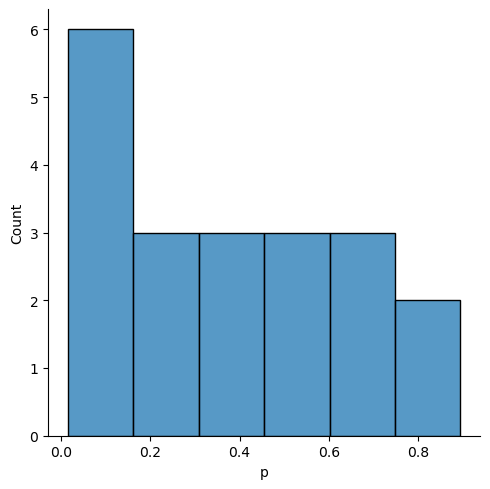

In [28]:

# let's repeat the "no cheating" process 20x
# each time doing a random train/test split
# 
# CLASSICAL P-HACKING
metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=False,
    cheat_on_predictor_fit=False,
    min_features_to_select=10,
    max_features_to_select=10,
    n_repeats=20,
    verbose_level=0)
g = sns.displot(metrics, x="p")
g.savefig("p-histogram-no-cheating-10-features-logistic-regression-20-repeats.png")

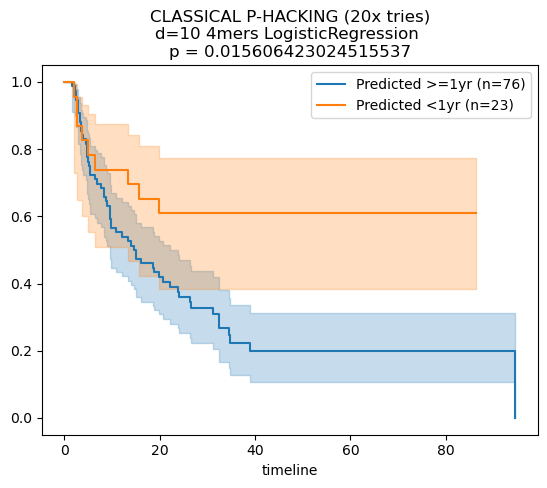

In [29]:

ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr (n=%d)" % (len(df_no),),
    title="CLASSICAL P-HACKING (20x tries)\nd=10 4mers LogisticRegression \np = %s" % metrics["p"].min(),
    filename="km-classical-p-hacking-20x-repeats-10-4mer-features-logistic-regression.png")

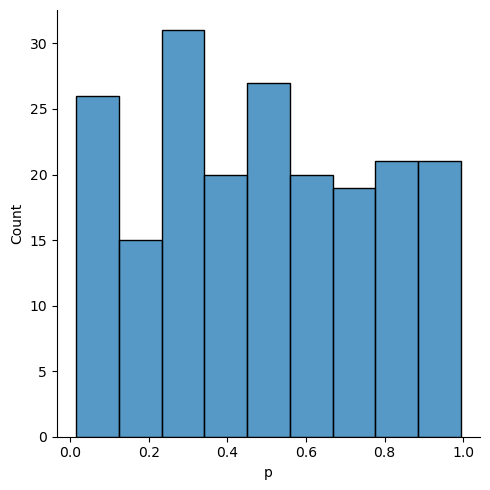

In [30]:

# let's repeat the "no cheating" process 200x
# each time doing a random train/test split
# 
# CLASSICAL P-HACKING
metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=False,
    cheat_on_predictor_fit=False,
    min_features_to_select=10,
    max_features_to_select=10,
    n_repeats=200,
    verbose_level=0)
g = sns.displot(metrics, x="p")
g.savefig("p-histogram-no-cheating-10-features-logistic-regression-200-repeats.png")

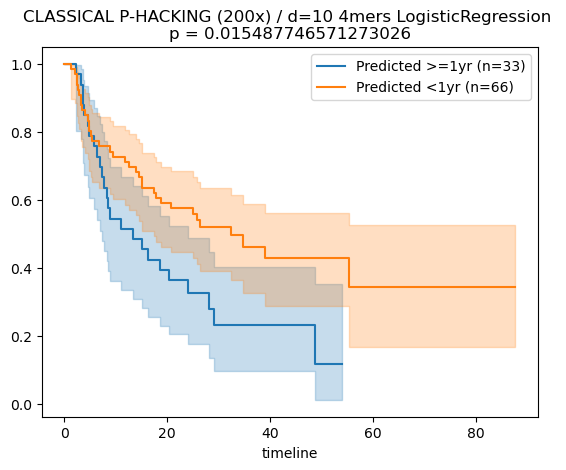

In [31]:

ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr (n=%d)" % (len(df_no),),
    title="CLASSICAL P-HACKING (200x) / d=10 4mers LogisticRegression \np = %s" % metrics["p"].min(),
    filename="km-classical-p-hacking-200x-repeats-10-4mer-features-logistic-regression.png")

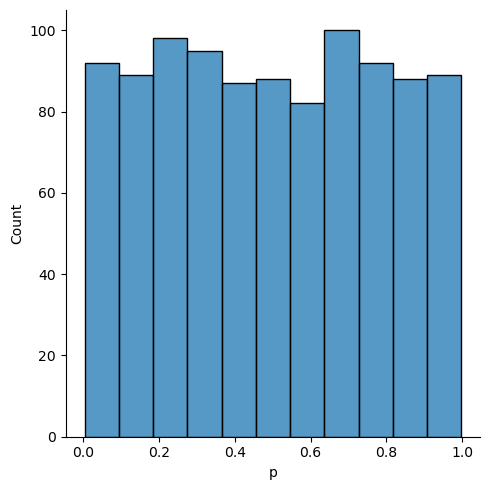

In [32]:

# let's repeat the "no cheating" process 1000x
# each time doing a random train/test split
# 
# CLASSICAL P-HACKING
metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=False,
    cheat_on_predictor_fit=False,
    min_features_to_select=10,
    max_features_to_select=10,
    n_repeats=1000,
    verbose_level=0)
g = sns.displot(metrics, x="p")
g.savefig("p-histogram-no-cheating-10-features-logistic-regression-1000-repeats.png")

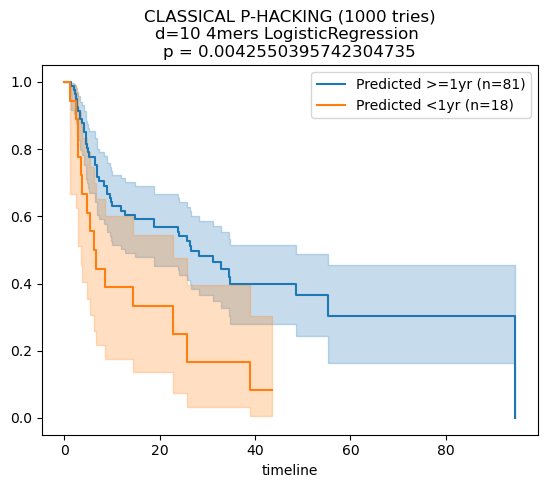

In [33]:

ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr (n=%d)" % (len(df_no),),
    title="CLASSICAL P-HACKING (1000 tries)\nd=10 4mers LogisticRegression \np = %s" % metrics["p"].min(),
    filename="km-classical-p-hacking-1000x-repeats-10-4mer-features-logistic-regression.png")

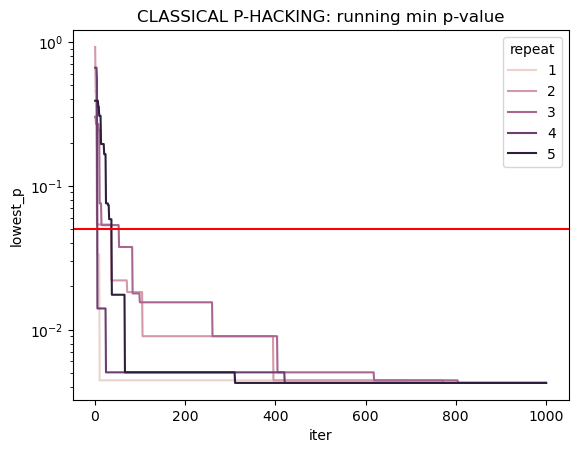

In [34]:
# how quickly do p-values goes down vs. number of samples from classical p-hacking?

def running_min(ps):
    running_min_p_values = []
    best_so_far = ps[0]
    for p in ps:
        if p < best_so_far:
            best_so_far = p
        running_min_p_values.append(best_so_far)
    return running_min_p_values
def shuffled_running_mins(ps, n_repeats=5):
    cols = {"repeat": [], "lowest_p": [], "iter": []}
    n = len(ps)
    for r in range(n_repeats):
        np.random.shuffle(ps)
        cols["repeat"].extend([r + 1] * n)
        cols["lowest_p"].extend(running_min(ps))
        cols["iter"].extend(np.arange(n) + 1)
    return pd.DataFrame(cols)

df_p_hacking = shuffled_running_mins(metrics["p"])
sns.lineplot(data=df_p_hacking, x="iter", y="lowest_p", hue="repeat")
plt.axhline(y=0.05, color='r', linestyle='-')

plt.yscale('log')
plt.title("CLASSICAL P-HACKING: running min p-value")
plt.savefig("classical-p-hacking-running-min-p-value.png")

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


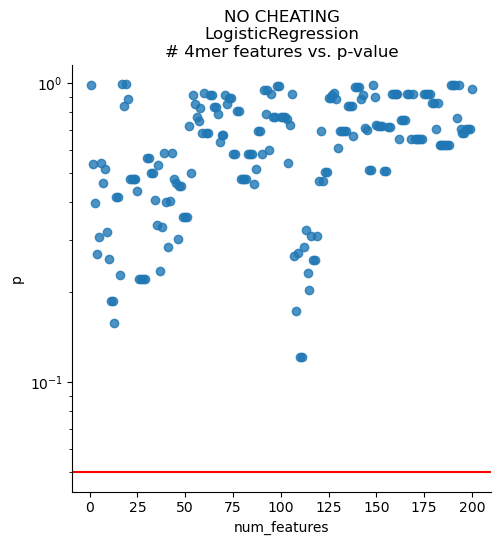

In [36]:
# What if we vary how many features we consider but 
# pick them using only using training data?
metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=False,
    cheat_on_predictor_fit=False)


# features vs. p-values without cheating

sns.lmplot(metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("NO CHEATING\nLogisticRegression\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("no-cheating-4mer-features-vs-p-value-logistic-regression.png")

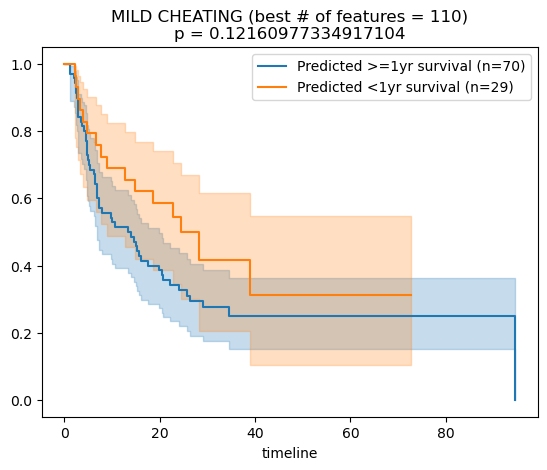

In [37]:
# KM split with only mild cheating - best # of features but a legitimate train/test split
lowest_p = metrics["p"].min()
lowest_p_index = metrics["p"].argmin()
num_features_at_lowest_p = metrics["num_features"].iloc[lowest_p_index]
ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr survival (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr survival (n=%d)" % (len(df_no),),
    title="MILD CHEATING (best # of features = %d)\np = %s" % (num_features_at_lowest_p, lowest_p)
)
ax.figure.savefig("mild-cheating-km-best-4mer-features-logistic-regression.png")

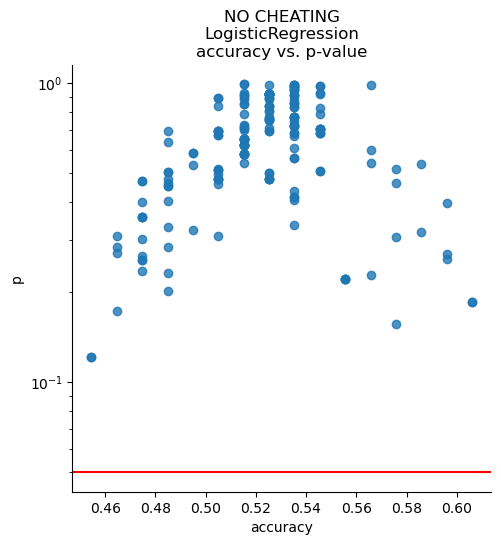

In [38]:
# accuracy vs p-value without cheating
sns.lmplot(metrics, x="accuracy", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.yscale('log')
plt.title("NO CHEATING\nLogisticRegression\naccuracy vs. p-value")
plt.savefig("no-cheating-accuracy-vs-p-value-4mer-logistic-regression.png")

In [39]:
# OK, what about EXTREME CHEATING?
# What if we pick features only using training data?

metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=True,
    cheat_on_predictor_fit=True)



Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


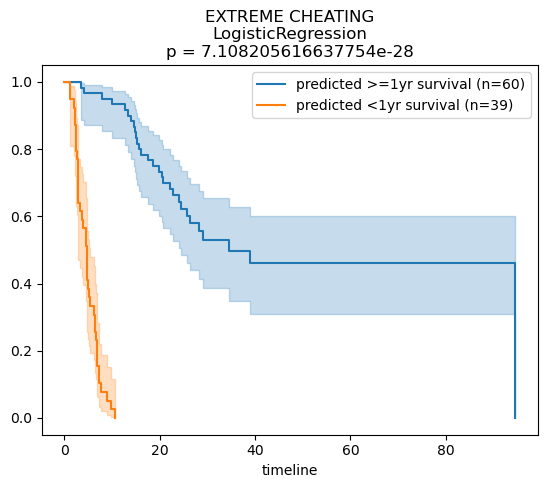

In [40]:
# KM split with EXTREME CHEATING
ax = plot_km(
    df_yes,
    df_no, 
    label_yes="predicted >=1yr survival (n=%d)" % (len(df_yes),),
    label_no="predicted <1yr survival (n=%d)" % (len(df_no),),
    title="EXTREME CHEATING\nLogisticRegression\np = %s" % metrics["p"].min())
ax.figure.savefig("extreme-cheating-km-best-4mer-features-logistic-regression.png")


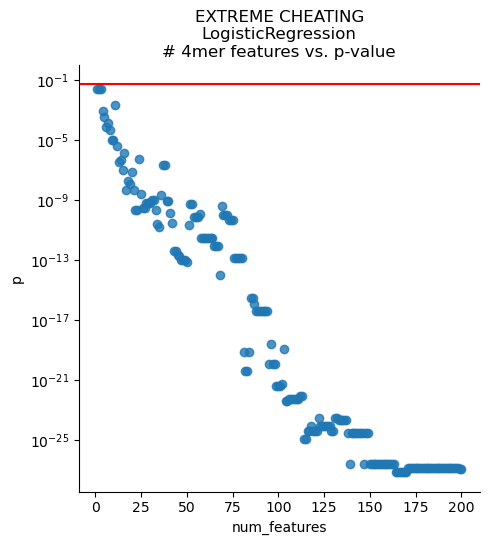

In [41]:
# EXTREME CHEATING: # features vs p-value
sns.lmplot(metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("EXTREME CHEATING\nLogisticRegression\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("extreme-cheating-4mer-features-vs-p-value-logistic-regression.png")

In [42]:
"""
===================================
|| CHEATING BY FEATURE SELECTION ||
===================================

       !
       !
       ^
      / \
     /___\
    |=   =|
    |     |
    |     |
    |     |
    |     |
    |     |
    |     |
    |     |
    |     |
    |     |
   /|##!##|\
  / |##!##| \
 /  |##!##|  \
|  / ^ | ^ \  |
| /  ( | )  \ |
|/   ( | )   \|
    ((   ))
   ((  :  ))
   ((  :  ))
    ((   ))
     (( ))
      ( )
       .
       .
       .

"""

#
# OK, now let's pick features that are informative on the whole dataset
# before training a model on just a training subset
metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    cheat_on_feature_selection=True,
    cheat_on_predictor_fit=False,
    min_features_to_select=1,
    max_features_to_select=200)


Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


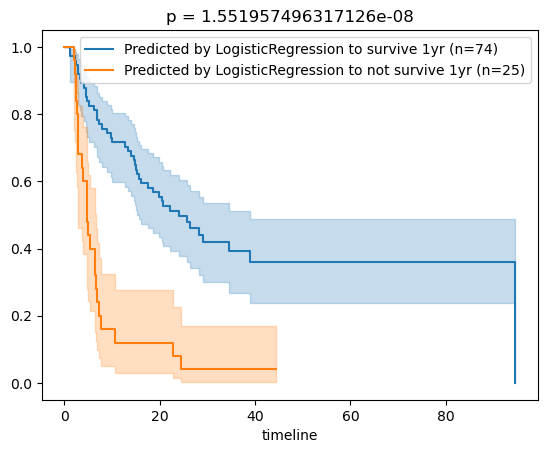

In [43]:

ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted by LogisticRegression to survive 1yr (n=%d)" % (len(df_yes),),
    label_no="Predicted by LogisticRegression to not survive 1yr (n=%d)" % (len(df_no),),
    title="p = %s" % metrics["p"].min(),
    filename="km-best-4mer-features-logistic-regression.png")

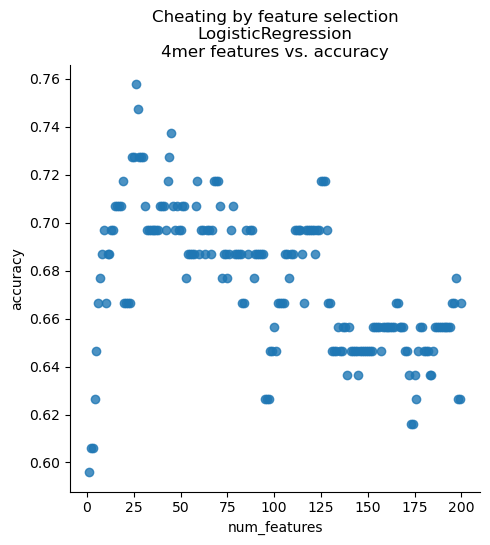

In [44]:

sns.lmplot(
    data=metrics, x="num_features", y="accuracy", fit_reg=False)
plt.title("Cheating by feature selection\nLogisticRegression\n4mer features vs. accuracy")
plt.savefig("num-4mer-features-vs-accuracy-logistic-regression.png")

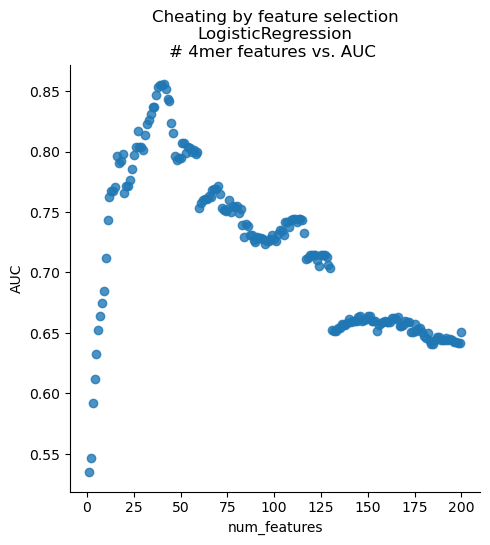

In [45]:
sns.lmplot(metrics, x="num_features", y="AUC", fit_reg=False)
plt.title("Cheating by feature selection\nLogisticRegression\n# 4mer features vs. AUC ")
plt.savefig("num-4mer-features-vs-auc-4mer-logistic-regression.png")

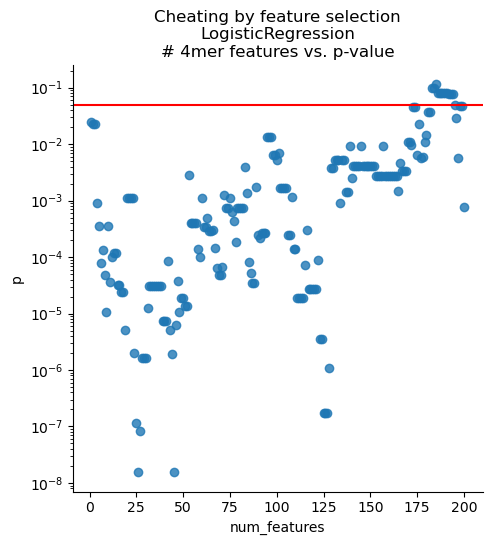

In [46]:
sns.lmplot(metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection\nLogisticRegression\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("num-4mer-features-vs-p-value-logistic-regression.png")

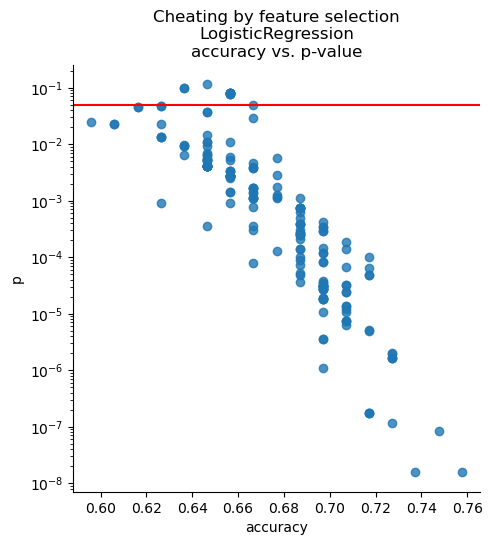

In [47]:
sns.lmplot(metrics, x="accuracy", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.yscale('log')
plt.title("Cheating by feature selection\nLogisticRegression\naccuracy vs. p-value")
plt.savefig("accuracy-vs-p-value-4mer-logistic-regression.png")

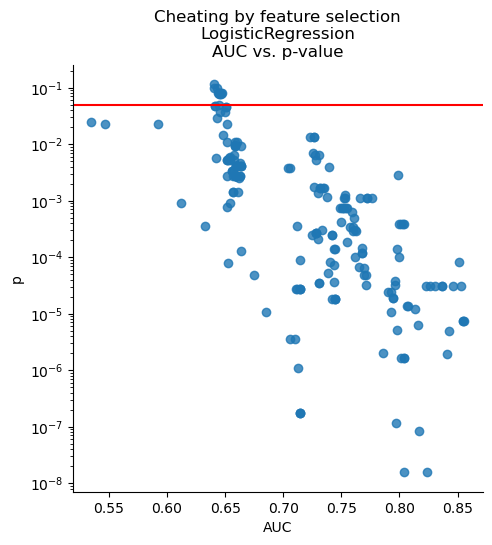

In [48]:
sns.lmplot(metrics, x="AUC", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.yscale('log')
plt.title("Cheating by feature selection\nLogisticRegression\nAUC vs. p-value")
plt.savefig("auc-vs-p-value-4mer-logistic-regression.png")

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


<Axes: title={'center': 'Cheating by feature selection\nRandomForest\np = 1.6991575032075715e-14'}, xlabel='timeline'>

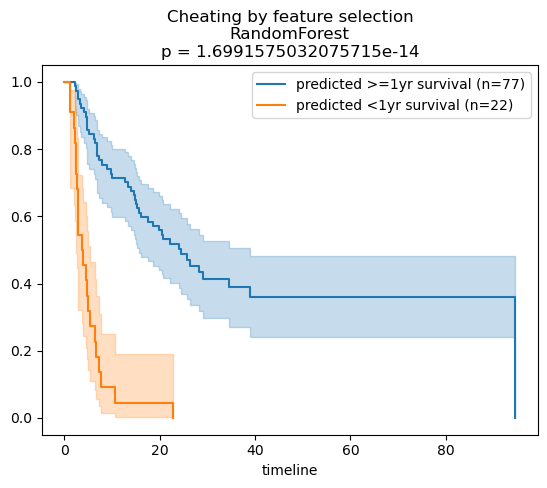

In [49]:
# when doing feature selection cheating, does a Random Forest do better than a Logistic Regression?

metrics, df_yes, df_no = evaluate_model(
    df_survival=df_join,
    features=order_to_count_features[4],
    predictor=RandomForestClassifier(),
    cheat_on_feature_selection=True,
    cheat_on_predictor_fit=False)
# KM split with feature selection cheating & RandomForest
plot_km(
    df_yes,
    df_no, 
    label_yes="predicted >=1yr survival (n=%d)" % (len(df_yes),),
    label_no="predicted <1yr survival (n=%d)" % (len(df_no),),
    title="Cheating by feature selection\nRandomForest\np = %s" % metrics["p"].min(),
    filename="km-best-4mer-features-random-forest.png")

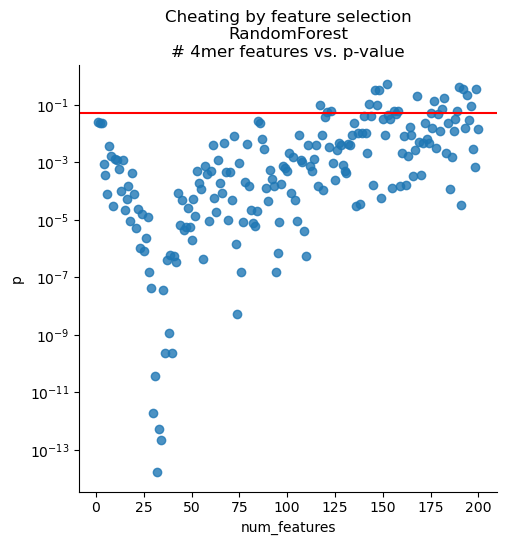

In [50]:
# more consistently unable to memorize with higher numbers of features
sns.lmplot(data=metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection\nRandomForest\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("num-4mer-features-vs-accuracy-random-forest.png")

In [51]:
# ...is it the model capacity? Does that mean a lower capacity regression would do better?

metrics, df_yes, df_no = evaluate_model(
    features=order_to_count_features[4].values,
    df_survival=df_join,
    predictor=LogisticRegression(C=100),
)


Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


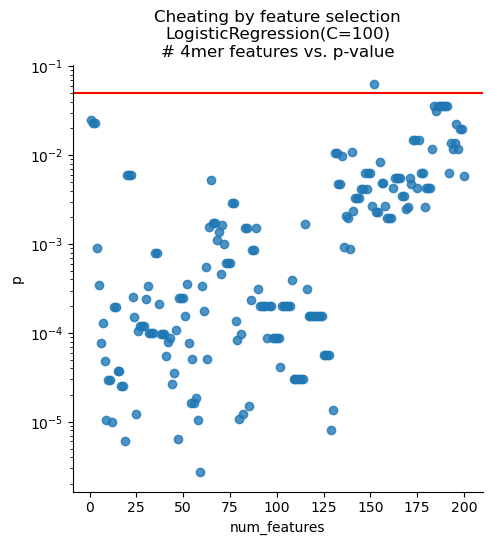

In [52]:
sns.lmplot(metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection\nLogisticRegression(C=100)\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("num-4mer-features-vs-accuracy-logistic-regression-high-C.png")

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


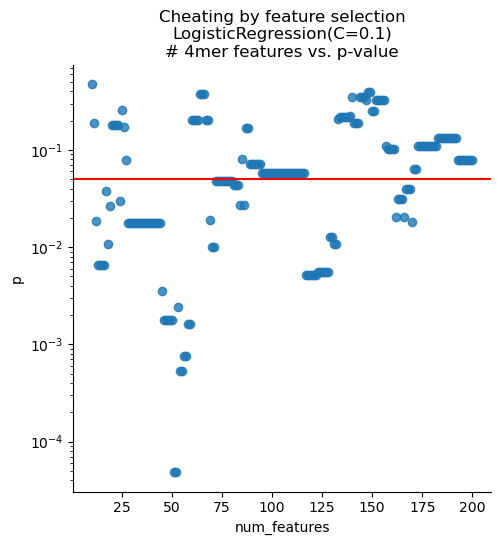

In [53]:
# conversely, would a higher capacity regression do worse?

metrics, df_yes, df_no = evaluate_model(
    features=order_to_count_features[4].values,
    df_survival=df_join,
    predictor=LogisticRegression(C=0.1),
)

sns.lmplot(metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection\nLogisticRegression(C=0.1)\n# 4mer features vs. p-value")
plt.yscale('log')
plt.savefig("num-4mer-features-vs-accuracy-logistic-regression-low-C.png")

In [54]:
# do the amino acid features matter at all? Would we do just as well with random numbers?

random_data = (np.random.rand(*order_to_count_features[4].values.shape) > 0.5).astype(int)
df_random = pd.DataFrame(random_data, columns=order_to_count_features[4].columns)
df_random


,A,C,D,E,F,G,H,I,K,L,...,SMAL,SPSL,SSSF,SSTI,TFFI,TFSF,TLSA,TPMY,TSAA,VLLF
0,0,0,1,0,1,1,0,1,0,1,...,0,0,1,1,1,0,1,1,0,1
1,0,1,0,1,1,1,1,0,0,0,...,0,0,1,1,1,1,0,0,0,0
2,1,1,0,0,1,1,0,1,1,0,...,0,0,0,1,0,1,1,1,0,1
3,0,0,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,1,0,0,0,1,...,0,1,1,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0,0,0,1,0,1,0,0,0,1,...,0,1,1,1,0,1,0,1,0,1
194,0,0,0,1,1,1,1,0,1,1,...,1,1,1,1,0,0,1,0,1,1
195,0,1,1,0,0,0,1,1,1,1,...,0,0,0,1,0,0,1,0,0,0
196,0,1,0,1,1,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,1


Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


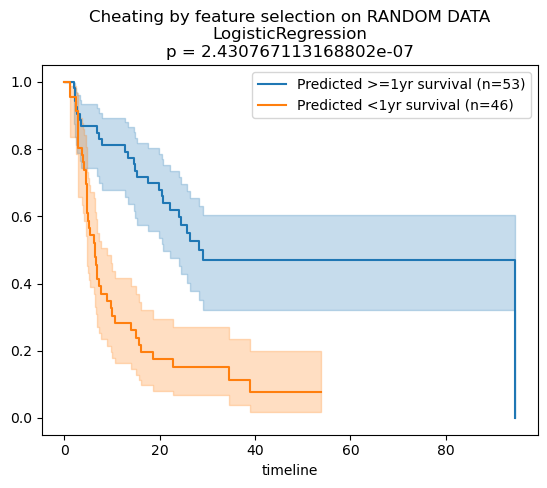

In [55]:

metrics, df_yes, df_no = evaluate_model(
    # make X a random binary vector the same shape as the original features
    df_survival=df_join,
    features=df_random)

# KM split with feature selection cheating & RandomForest
ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr survival (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr survival (n=%d)" % (len(df_no),),
    title="Cheating by feature selection on RANDOM DATA\nLogisticRegression\np = %s" % metrics["p"].min())
ax.figure.savefig("km-best-uniform-random-features.png")

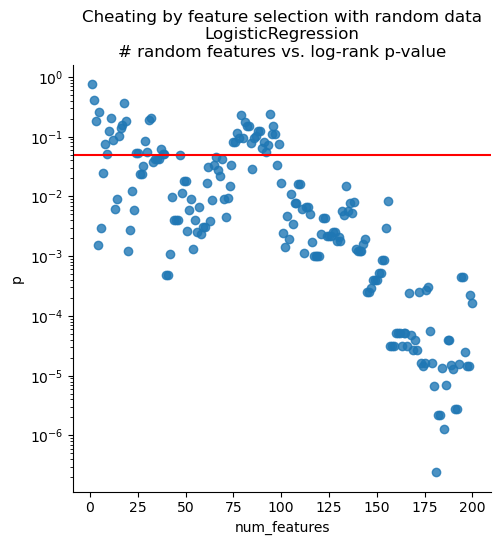

In [56]:
sns.lmplot(data=metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection with random data\nLogisticRegression\n# random features vs. log-rank p-value")
plt.yscale('log')
plt.savefig('num-random-features-vs-p-value.png')

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


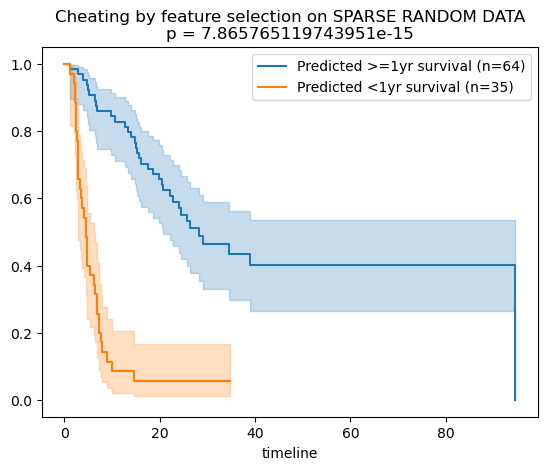

In [57]:
# does sparsity make it better?

random_data = (np.random.rand(*order_to_count_features[4].values.shape) > 0.95).astype(int)

df_random = pd.DataFrame(random_data, columns=order_to_count_features[4].columns)

metrics, df_yes, df_no = evaluate_model(
    # make X a random binary vector the same shape as the original features
    df_survival=df_join,
    features=df_random)

# KM split with feature selection of sparse random binary vectors
ax = plot_km(
    df_yes,
    df_no, 
    label_yes="Predicted >=1yr survival (n=%d)" % (len(df_yes),),
    label_no="Predicted <1yr survival (n=%d)" % (len(df_no),),
    title="Cheating by feature selection on SPARSE RANDOM DATA\np = %s" % metrics["p"].min())
ax.figure.savefig("km-best-sparse-random-features.png")

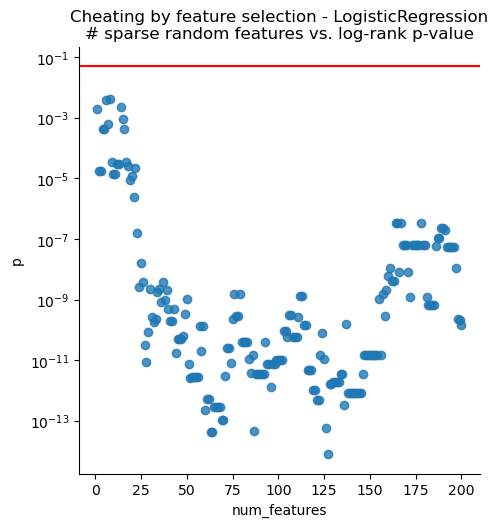

In [58]:
sns.lmplot(data=metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection - LogisticRegression\n# sparse random features vs. log-rank p-value")
plt.yscale('log')
plt.savefig('num-sparse-random-features-vs-p-value.png')

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


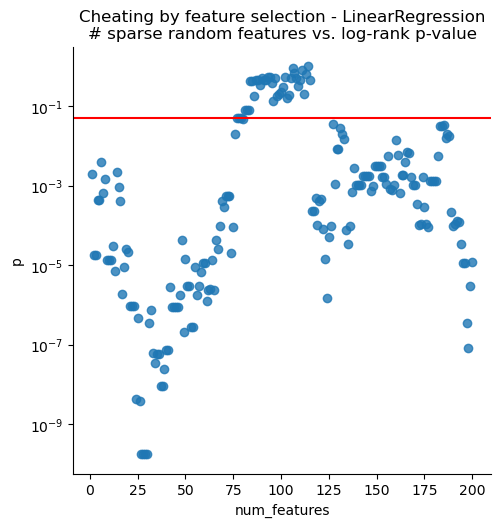

In [59]:
# what if we make extremely simple: linear regression!
from sklearn.linear_model import Lasso, LinearRegression

metrics, df_yes, df_no = evaluate_model(
    # make X a random binary vector the same shape as the original features
    df_survival=df_join,
    features=df_random,
    predictor=LinearRegression())

sns.lmplot(data=metrics, x="num_features", y="p", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Cheating by feature selection - LinearRegression\n# sparse random features vs. log-rank p-value")
plt.yscale('log')
plt.savefig('num-sparse-random-features-vs-p-value-linear-regression.png')

In [81]:
# let's dig a little more into the role of sparsity

dataframes = []
for sparsity_percent in tqdm(np.arange(10, 100, 20)):
    t = sparsity_percent / 100.0
    random_data = (np.random.rand(*order_to_count_features[4].values.shape) <= t).astype(int)    
    metrics, df_yes, df_no = evaluate_model(
        # make X a random binary vector the same shape as the original features
        df_survival=df_join,
        features=random_data)
    metrics["sparsity"] = t
    metrics["sparsity_percent"] = sparsity_percent
    dataframes.append(metrics)
metrics = pd.concat(dataframes)



  0%|                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


 20%|███████████████████████████████▊                                                                                                                               | 1/5 [00:01<00:07,  1.95s/it]

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


 40%|███████████████████████████████████████████████████████████████▌                                                                                               | 2/5 [00:04<00:06,  2.06s/it]

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


 60%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 3/5 [00:06<00:04,  2.32s/it]

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4/5 [00:09<00:02,  2.46s/it]

Repeat #1: 99x1516 training samples (57.6% survival), 99x1516 test samples (56.6% survival), n_features 1:200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


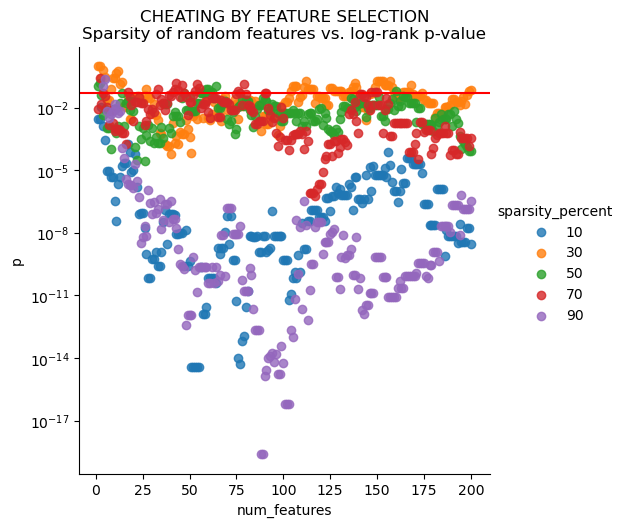

In [86]:

sns.lmplot(data=metrics, x="num_features", y="p", hue="sparsity_percent", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("CHEATING BY FEATURE SELECTION\nSparsity of random features vs. log-rank p-value")
plt.yscale('log')
plt.savefig('varying-sparsity-random-features-vs-p-value-logistic-regression')

In [64]:
# lastly, let's dig a little more into the role of the number of features

dataframes = []
for n_features in tqdm([200, 2000, 20000]):
    random_data = (np.random.rand(len(df_join), n_features) > 0.9).astype(int)    
    metrics, df_yes, df_no = evaluate_model(
        # make X a random binary vector the same shape as the original features
        df_survival=df_join,
        features=random_data)
    metrics["num_total_features"] = n_features
    dataframes.append(metrics)
metrics = pd.concat(dataframes)


  0%|                                                                                                                                                                       | 0/3 [00:00<?, ?it/s]

Repeat #1: 99x200 training samples (57.6% survival), 99x200 test samples (56.6% survival), n_features 1:200


 33%|█████████████████████████████████████████████████████                                                                                                          | 1/3 [00:01<00:03,  1.93s/it]

Repeat #1: 99x2000 training samples (57.6% survival), 99x2000 test samples (56.6% survival), n_features 1:200


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2/3 [00:03<00:02,  2.00s/it]

Repeat #1: 99x20000 training samples (57.6% survival), 99x20000 test samples (56.6% survival), n_features 1:200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.04s/it]


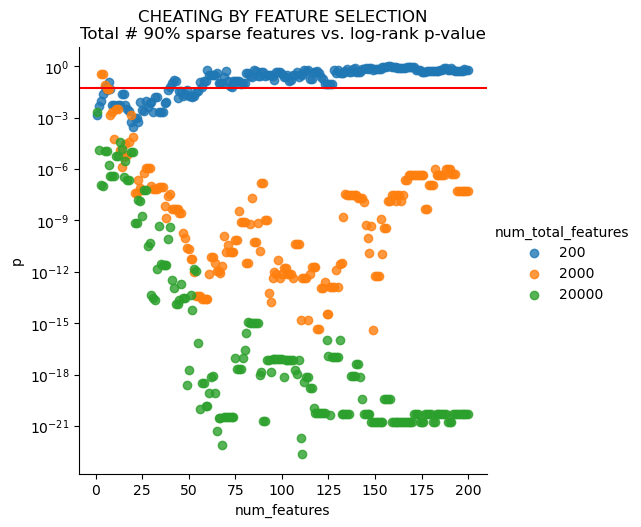

In [67]:

sns.lmplot(data=metrics, x="num_features", y="p", hue="num_total_features", fit_reg=False)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("CHEATING BY FEATURE SELECTION\nTotal # 90% sparse features vs. log-rank p-value")
plt.yscale('log')
plt.savefig('varying-sparsity-random-features-vs-p-value-logistic-regression.png')